In [ ]:
import pandas as pd

def load_and_process_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    data = [line.strip().split(':') for line in lines]
    df = pd.DataFrame(data, columns=['label', 'tweet_id'])
    df['tweet_id'] = df['tweet_id'].astype(str)
    label_map = {'true': 1, 'false': 0, 'unverified': 2, 'non-rumor': 3}
    df['label_encoded'] = df['label'].map(label_map)
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    return df

file_path = '/content/label.txt'  # Change this path if needed
df = load_and_process_data(file_path)
print(df.head())
print("\nLabel distribution:\n", df['label'].value_counts())

        label            tweet_id  label_encoded
0       false  656955120626880512              0
1        true  615689290706595840              1
2       false  613404935003217920              0
3  unverified  731166399389962242              2
4  unverified  714598641827246081              2

Label distribution:
 label
true          207
false         205
non-rumor     205
unverified    201
Name: count, dtype: int64


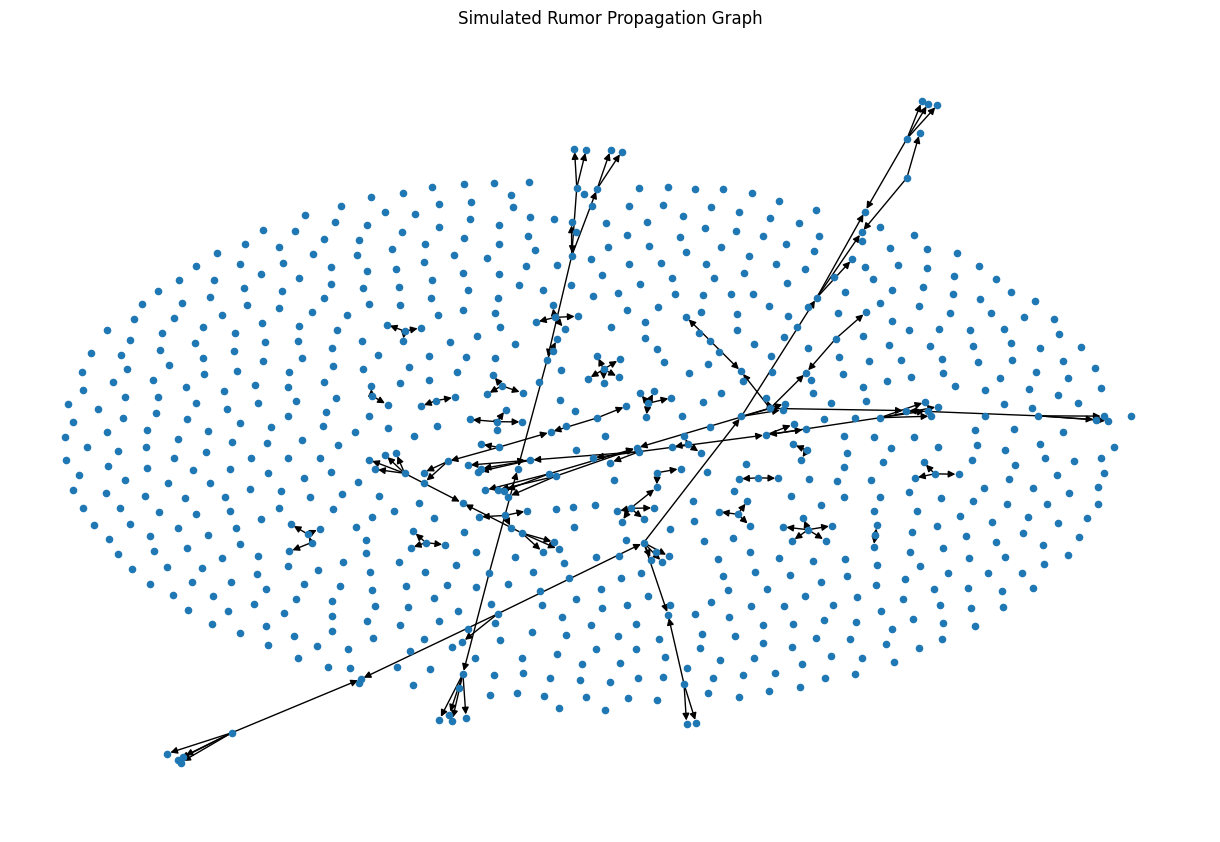

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(42)  # For reproducibility
G = nx.DiGraph()
G.add_nodes_from(df['tweet_id'])

sources = random.sample(list(df['tweet_id']), 50)
for source in sources:
    targets = random.sample(list(df['tweet_id'].drop_duplicates()), random.randint(2, 5))
    for target in targets:
        if source != target:
            G.add_edge(source, target)

plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=False, node_size=20, arrows=True)
plt.title('Simulated Rumor Propagation Graph')
plt.show()

In [ ]:
rumor_tweets = df[df['label'].isin(['true', 'false', 'unverified'])]
G_rumor = G.subgraph(rumor_tweets['tweet_id'])

print("Rumor Subgraph Nodes:", G_rumor.number_of_nodes())
print("Rumor Subgraph Edges:", G_rumor.number_of_edges())


Rumor Subgraph Nodes: 613
Rumor Subgraph Edges: 89


In [ ]:
# Compute centrality metrics for the rumor subgraph
degree_centrality = nx.degree_centrality(G_rumor)
betweenness_centrality = nx.betweenness_centrality(G_rumor)
closeness_centrality = nx.closeness_centrality(G_rumor)

# Show top nodes by degree centrality
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by degree centrality:")
for node, score in top_degree:
    print(f"{node}: {score:.4f}")

Top 5 nodes by degree centrality:
524966904885428226: 0.0082
681767380305985536: 0.0082
614650850393391104: 0.0082
715515982584881152: 0.0065
672927317191229440: 0.0065


In [ ]:
from networkx.algorithms.community import girvan_newman
communities = girvan_newman(G_rumor)
first_level_communities = next(communities)
print(f"Detected {len(first_level_communities)} communities in the rumor subgraph.")

Detected 525 communities in the rumor subgraph.


In [ ]:
rumor_tweets = df[df["label"].isin(["true", "false", "unverified"])]

# Create a subgraph of rumor tweets
G_rumor = G.subgraph(rumor_tweets["tweet_id"])

🔎 Estimated rumor source (Jordan Center): 614650850393391104


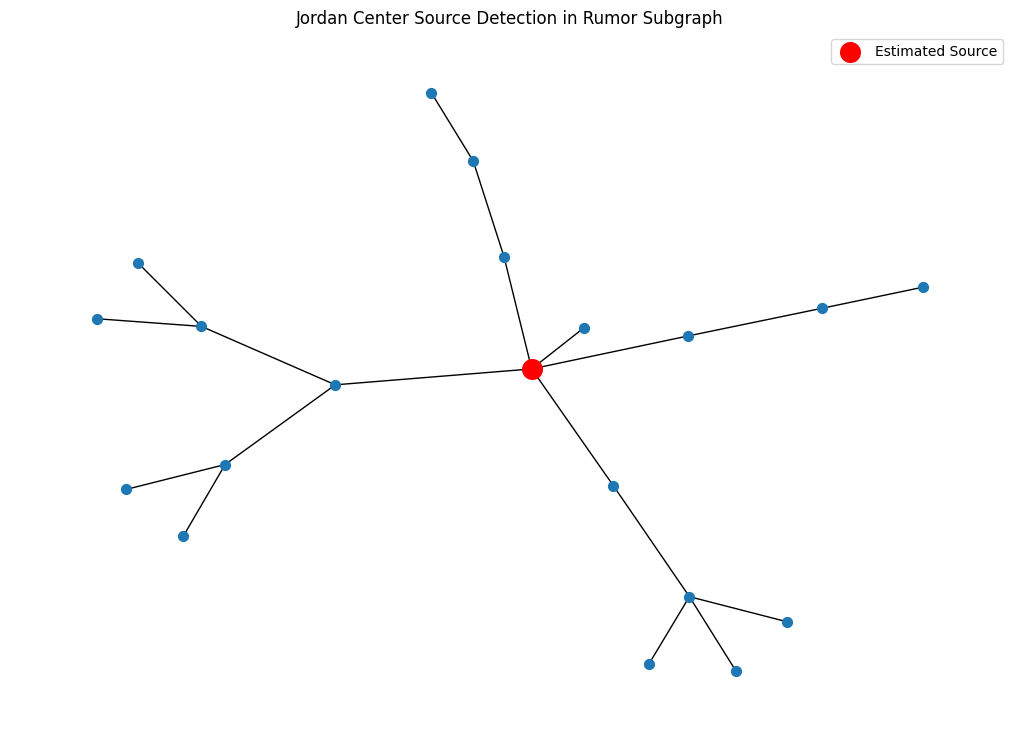

In [ ]:
# Step 1: Convert rumor subgraph to undirected
G_rumor_undirected = G_rumor.to_undirected()

# Step 2: Get the largest connected component
largest_cc = max(nx.connected_components(G_rumor_undirected), key=len)
G_main = G_rumor_undirected.subgraph(largest_cc).copy()

# Step 3: Compute eccentricity and Jordan Center
eccentricities = nx.eccentricity(G_main)
jordan_center = min(eccentricities, key=eccentricities.get)

print("🔎 Estimated rumor source (Jordan Center):", jordan_center)

# Step 4: Visualize
import matplotlib.pyplot as plt

pos = nx.spring_layout(G_main)
plt.figure(figsize=(10, 7))
nx.draw(G_main, pos, node_size=50, with_labels=False)
nx.draw_networkx_nodes(G_main, pos, nodelist=[jordan_center], node_color='red', label="Estimated Source", node_size=200)
plt.title("Jordan Center Source Detection in Rumor Subgraph")
plt.legend()
plt.show()


In [ ]:
# Step 1: Simulate a 'true' source from within the subgraph
true_source = random.choice(list(G_main.nodes))
print("🎯 Simulated True Source:", true_source)

# Step 2: Compute the shortest path distance (in hops)
try:
    distance = nx.shortest_path_length(G_main, source=true_source, target=jordan_center)
    print(f"✅ Distance from True Source to Estimated Source (Jordan Center): {distance} hops")
except nx.NetworkXNoPath:
    print("⚠️ No path between true source and estimated source in this subgraph.")#

🎯 Simulated True Source: 765887221736046592
✅ Distance from True Source to Estimated Source (Jordan Center): 1 hops


In [ ]:
import pandas as pd
import random

# Step 1: Load and process label.txt
with open("/content/label.txt", "r") as f:
    lines = f.readlines()

data = [line.strip().split(":") for line in lines]
df = pd.DataFrame(data, columns=["label", "tweet_id"])
df["tweet_id"] = df["tweet_id"].astype(str)

# Step 2: Simulate text for each tweet_id
sample_texts = [
    "Breaking news! This event just happened.",
    "I can't believe this is true. Wow!",
    "Check the facts before spreading rumors.",
    "Unconfirmed sources report something strange.",
    "Authorities have denied the incident.",
    "Here's what really happened, according to experts.",
    "Spreading false information is dangerous.",
    "We need to wait for official confirmation.",
    "Here's what people are saying on Twitter.",
    "Some claim it's real, others say fake."
]

random.seed(42)
df["text"] = df["tweet_id"].apply(lambda x: random.choice(sample_texts))


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df["clean_text"] = df["text"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

label_map = {"true": 1, "false": 0, "unverified": 2, "non-rumor": 3}
df["label_encoded"] = df["label"].map(label_map)

tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df["clean_text"]).toarray()
y = df["label_encoded"]


<ipython-input-15-3c7b308c1732>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


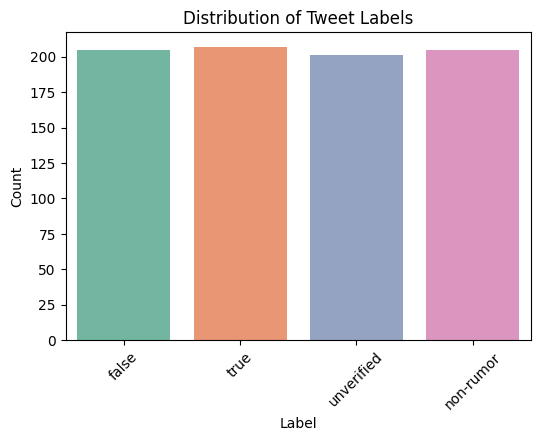

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Tweet Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


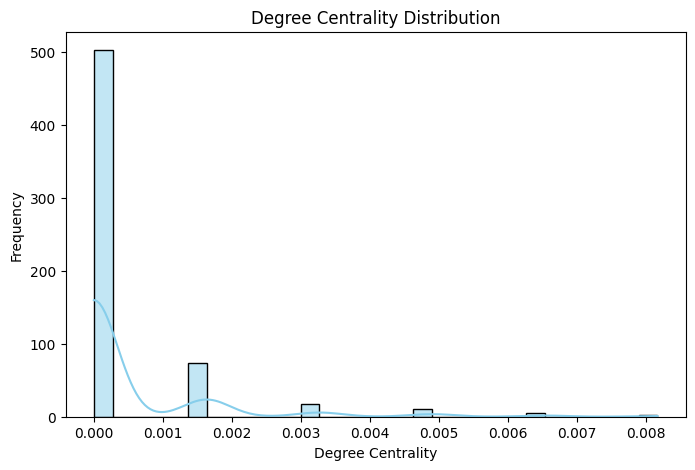

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(list(degree_centrality.values()), kde=True, bins=30, color='skyblue')
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.show()


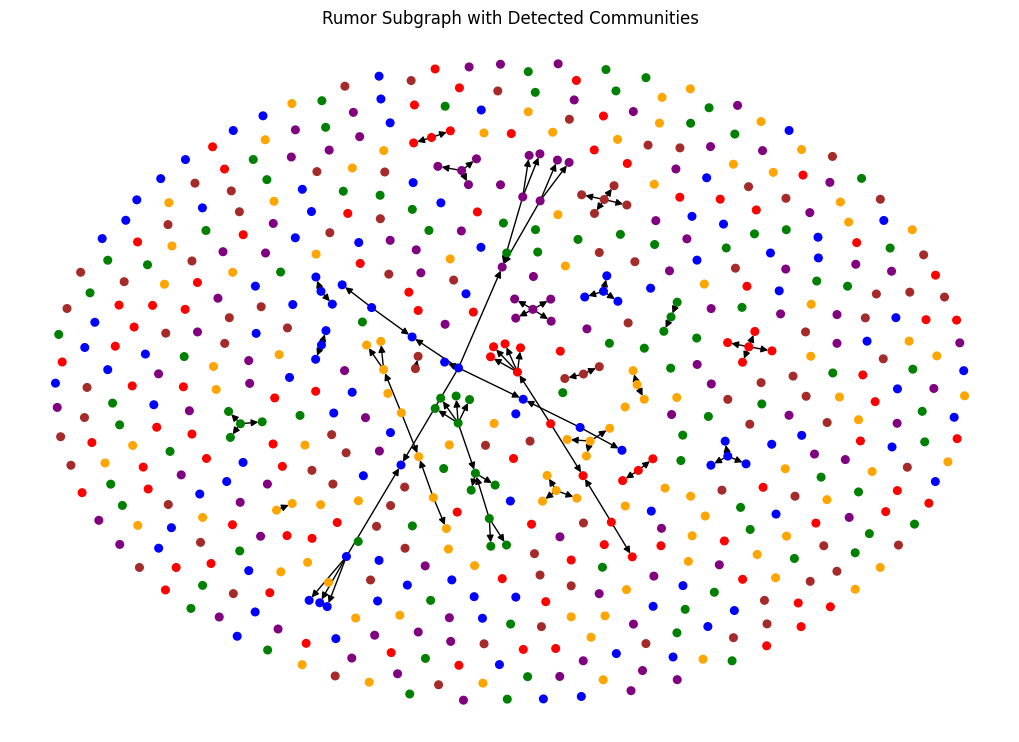

In [ ]:
color_map = {}
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, community in enumerate(first_level_communities):
    for node in community:
        color_map[node] = colors[i % len(colors)]

node_colors = [color_map.get(node, 'gray') for node in G_rumor.nodes()]

plt.figure(figsize=(10, 7))
nx.draw(G_rumor, node_color=node_colors, node_size=30, with_labels=False)
plt.title('Rumor Subgraph with Detected Communities')
plt.show()


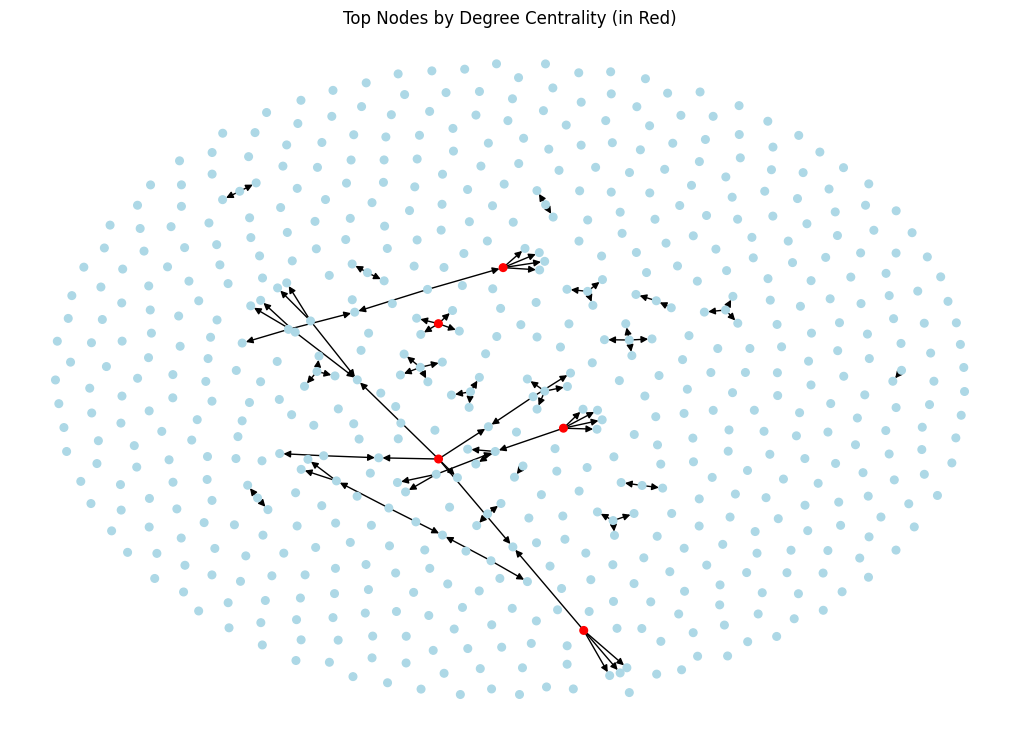

In [ ]:
top_nodes = [node for node, _ in top_degree]
node_colors = ['red' if node in top_nodes else 'lightblue' for node in G_rumor.nodes()]

plt.figure(figsize=(10, 7))
nx.draw(G_rumor, node_color=node_colors, node_size=30, with_labels=False)
plt.title('Top Nodes by Degree Centrality (in Red)')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Use tweet_id encoding as feature (illustrative only)
df['tweet_id_int'] = df['tweet_id'].astype('category').cat.codes
X = tfidf.fit_transform(df["clean_text"])

y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68        38
           1       0.80      0.88      0.83        40
           2       0.79      0.82      0.81        38
           3       0.93      0.77      0.84        48

    accuracy                           0.79       164
   macro avg       0.79      0.79      0.79       164
weighted avg       0.80      0.79      0.79       164



In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.7926829268292683
Macro F1 Score: 0.7907453833086744
